<a href="https://colab.research.google.com/github/nurainizafiraaa/Final-Project-Data-Science-/blob/main/Final_Project_Data_Science_Zafira_Nuraini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Library**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import statsmodels.tsa.api as sm
import tensorflow as tf
import xgboost as xgb
import plotly.express as px
import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')

from matplotlib import rcParams
from prophet import Prophet
from prophet.diagnostics import cross_validation
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import month_plot, plot_acf, plot_pacf, quarter_plot

# **Import Data**

In [ ]:
url = 'https://drive.google.com/uc?id=16kKCVAWyZ1jOgc2EnXsCmHpAIEvXMaew'
df = pd.read_csv(url)

In [ ]:
# Sort values by date
df.sort_values(
    by=["settlement_date", "settlement_period"], inplace=True, ignore_index=True
)

In [ ]:
df.head()

settlement_date  settlement_period period_hour     nd    tsd  \
0  2009-01-01 00:00:00                  1     0:00:00  37910  38704   
1  2009-01-01 00:30:00                  2     0:30:00  38047  38964   
2  2009-01-01 01:00:00                  3     1:00:00  37380  38651   
3  2009-01-01 01:30:00                  4     1:30:00  36426  37775   
4  2009-01-01 02:00:00                  5     2:00:00  35687  37298   

   england_wales_demand  embedded_wind_generation  embedded_wind_capacity  \
0                 33939                        54                    1403   
1                 34072                        53                    1403   
2                 33615                        53                    1403   
3                 32526                        50                    1403   
4                 31877                        50                    1403   

   embedded_solar_generation  embedded_solar_capacity  non_bm_stor  \
0                          0                        0            0   
1                          0                        0            0   
2                          0                        0            0   
3                          0                        0            0   
4                          0                        0            0   

   pump_storage_pumping  ifa_flow  ifa2_flow  britned_flow  moyle_flow  \
0                    33      2002          0             0        -161   
1                   157      2002          0             0        -160   
2                   511      2002          0             0        -160   
3                   589      1772          0             0        -160   
4                   851      1753          0             0        -160   

   east_west_flow  nemo_flow  is_holiday  
0               0          0           1  
1               0          0           1  
2               0          0           1  
3               0          0           1  
4               0          0           1

In [ ]:
df.shape

(278512, 19)

In [ ]:
# check dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278512 entries, 0 to 278511
Data columns (total 19 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   settlement_date            278512 non-null  object
 1   settlement_period          278512 non-null  int64 
 2   period_hour                278512 non-null  object
 3   nd                         278512 non-null  int64 
 4   tsd                        278512 non-null  int64 
 5   england_wales_demand       278512 non-null  int64 
 6   embedded_wind_generation   278512 non-null  int64 
 7   embedded_wind_capacity     278512 non-null  int64 
 8   embedded_solar_generation  278512 non-null  int64 
 9   embedded_solar_capacity    278512 non-null  int64 
 10  non_bm_stor                278512 non-null  int64 
 11  pump_storage_pumping       278512 non-null  int64 
 12  ifa_flow                   278512 non-null  int64 
 13  ifa2_flow                  278512 non-null  

**Mengubah format settlement date ke datetime**

In [ ]:
# --- Konversi tanggal (UK: dd-mm-yyyy) ---
df['settlement_date'] = pd.to_datetime(df['settlement_date'], dayfirst=True, errors='coerce')

if 'period_time' in df.columns or 'period_hour' in df.columns:

    # Pakai kolom jam/menit/detik yang sudah ada
    time_col = 'period_time' if 'period_time' in df.columns else 'period_hour'
    s = df[time_col].astype(str).str.strip()

    # Buang offset timezone di ujung seperti +00:00 / -05:00
    s = s.str.replace(r'([+-]\d{2}:\d{2}(:\d{2})?)$', '', regex=True)

    # Ambil pola HH:MM(:SS)
    s = s.str.extract(r'(\d{1,2}:\d{2}(:\d{2})?)', expand=False)[0]

    # Tangani "24:00:00" (rollover ke hari berikutnya)
    rollover = s.eq('24:00:00') | s.eq('24:00')
    s = s.mask(rollover, '00:00:00')

    td = pd.to_timedelta(s, errors='coerce')
    ts = df['settlement_date'].dt.normalize() + td
    ts = ts.where(~rollover, ts + pd.Timedelta(days=1))
    df['timestamp'] = ts

elif 'settlement_period' in df.columns:
    # Alternatif: pakai settlement_period (1..48) -> offset 30 menit
    offset_min = (df['settlement_period'].astype(int) - 1) * 30
    df['timestamp'] = df['settlement_date'].dt.normalize() + pd.to_timedelta(offset_min, unit='m')
else:
    raise ValueError("Tidak menemukan kolom waktu. Harus ada 'period_time'/'period_hour' atau 'settlement_period'.")

# Buang baris dengan timestamp tidak valid (NaT), set index, dan urutkan
df = df[~df['timestamp'].isna()].set_index('timestamp').sort_index()

**Rename Column**

In [ ]:
# Renaming columns
# df.rename(columns = {'nd': 'national_demand',
                    #'tsd': 'total_demand'}, inplace=True)

In [ ]:
df.describe().T

count                           mean  \
settlement_date              109920  2016-12-18 19:24:40.087336448   
settlement_period          109920.0                           24.5   
nd                         109920.0                   31360.694532   
tsd                        109920.0                   32864.634998   
england_wales_demand       109920.0                   28550.167185   
embedded_wind_generation   109920.0                    1281.485262   
embedded_wind_capacity     109920.0                    4450.482087   
embedded_solar_generation  109920.0                     868.660908   
embedded_solar_capacity    109920.0                    8691.160035   
non_bm_stor                109920.0                       6.867067   
pump_storage_pumping       109920.0                     305.565511   
ifa_flow                   109920.0                     941.304148   
ifa2_flow                  109920.0                      51.479176   
britned_flow               109920.0                     514.229449   
moyle_flow                 109920.0                    -128.811836   
east_west_flow             109920.0                     -51.658233   
nemo_flow                  109920.0                      175.58044   
is_holiday                 109920.0                       0.022271   

                                           min                  25%  \
settlement_date            2009-01-01 00:00:00  2013-01-04 11:52:30   
settlement_period                          1.0                12.75   
nd                                     13758.0              25013.0   
tsd                                    16832.0              26703.0   
england_wales_demand                       0.0              22782.0   
embedded_wind_generation                   0.0                551.0   
embedded_wind_capacity                  1403.0               2102.0   
embedded_solar_generation                  0.0                  0.0   
embedded_solar_capacity                    0.0               2044.0   
non_bm_stor                               -8.0                  0.0   
pump_storage_pumping                       0.0                  8.0   
ifa_flow                               -2056.0                316.0   
ifa2_flow                              -1029.0                  0.0   
britned_flow                           -1076.0                  0.0   
moyle_flow                              -505.0               -306.0   
east_west_flow                          -585.0               -212.0   
nemo_flow                              -1022.0                  0.0   
is_holiday                                 0.0                  0.0   

                                           50%                  75%  \
settlement_date            2016-12-22 11:45:00  2020-12-09 11:37:30   
settlement_period                         24.5                36.25   
nd                                     30629.0              37147.0   
tsd                                    31963.0              38351.0   
england_wales_demand                   27883.0              33820.0   
embedded_wind_generation                1029.0               1742.0   
embedded_wind_capacity                  4831.0               6527.0   
embedded_solar_generation                  0.0                891.0   
embedded_solar_capacity                11503.0              13080.0   
non_bm_stor                                0.0                  0.0   
pump_storage_pumping                      11.0                377.0   
ifa_flow                                1249.0               1898.0   
ifa2_flow                                  0.0                  0.0   
britned_flow                             748.0                994.0   
moyle_flow                              -153.0                 20.0   
east_west_flow                             0.0                  0.0   
nemo_flow                                  0.0                332.0   
is_holiday                                 0.0                  0.0   


# **Data Preparation & Feature Engineering**

## Check Bank Holiday

Since the dataset covers electricity demand for England and Wales and we want to do time series forecasting, the first step is to check that the two countries have the same bank holidays:

In [ ]:
# Compare England's and Wales' bank holiday

import holidays

bank_holiday_england = holidays.UK(
    subdiv="England", years=range(2009, 2024), observed=True
).items()
bank_holiday_wales = holidays.UK(
    subdiv="Wales", years=range(2009, 2024), observed=True
).items()

print(bank_holiday_england == bank_holiday_wales)

True


In [ ]:
# Create empty lists to store data
holiday_names = []
holiday_dates = []
holiday_names_observed = []
holiday_dates_observed = []

for date, name in sorted(bank_holiday_england):
    holiday_dates.append(date)
    holiday_names.append(name)
    # Pop the previous value as observed bank holidays takes place later
    if "Observed" in name:
        holiday_dates_observed.pop()
        holiday_names_observed.pop()

    holiday_names_observed.append(name)
    holiday_dates_observed.append(np.datetime64(date))

holiday_dates_observed[:5]

[np.datetime64('2009-01-01'),
 np.datetime64('2009-04-10'),
 np.datetime64('2009-04-13'),
 np.datetime64('2009-05-04'),
 np.datetime64('2009-05-25')]

Once the holidays are correctly loaded, we can compare the holiday_dates variable and the date in the dataset and store the boolean output in a new column

In [ ]:
df["is_holiday"] = df["settlement_date"].apply(
    lambda x: pd.to_datetime(x) in holiday_dates_observed
)

df["is_holiday"] = df["is_holiday"].astype(int)

df[df["is_holiday"] == 1].sample(7)

settlement_date  settlement_period period_hour     nd    tsd  \
timestamp                                                                 
2011-01-03      2011-01-03                  1     0:00:00  34451  36905   
2022-06-03      2022-06-03                  1     0:00:00  25133  25898   
2009-01-01      2009-01-01                  1     0:00:00  37910  38704   
2023-05-01      2023-05-01                  1     0:00:00  22173  25276   
2023-04-10      2023-04-10                  1     0:00:00  19629  23697   
2012-06-05      2012-06-05                  1     0:00:00  27730  29493   
2020-01-01      2020-01-01                  1     0:00:00  26340  27153   

            england_wales_demand  embedded_wind_generation  \
timestamp                                                    
2011-01-03                 31051                       427   
2022-06-03                 22566                      1361   
2009-01-01                 33939                        54   
2023-05-01                 20104                      2413   
2023-04-10                 18349                      2191   
2012-06-05                 24727                       201   
2020-01-01                 23821                      1244   

            embedded_wind_capacity  embedded_solar_generation  \
timestamp                                                       
2011-01-03                    1737                          0   
2022-06-03                    6545                          0   
2009-01-01                    1403                          0   
2023-05-01                    6545                          0   
2023-04-10                    6538                          0   
2012-06-05                    2019                          0   
2020-01-01                    6465                          0   

            embedded_solar_capacity  non_bm_stor  pump_storage_pumping  \
timestamp                                                                
2011-01-03                      113            0                  1450   
2022-06-03                    13734            0                     6   
2009-01-01                        0            0                    33   
2023-05-01                    15015            0                  1251   
2023-04-10                    15932            0                   403   
2012-06-05                     1487            0                   851   
2020-01-01                    13080            0                    15   

            ifa_flow  ifa2_flow  britned_flow  moyle_flow  east_west_flow  \
timestamp                                                                   
2011-01-03        -3          0             0        -401               0   
2022-06-03       423        773          1003        -159               0   
2009-01-01      2002          0             0        -161               0   
2023-05-01       989       -102           752        -451            -527   
2023-04-10      -937       -993          -817        -351             -67   
2012-06-05       996          0           994        -412               0   
2020-01-01      1703          0           852        -151             -47   

            nemo_flow  is_holiday  
timestamp                          
2011-01-03          0           1  
2022-06-03        976           1  
2009-01-01          0           1  
2023-05-01        161           1  
2023-04-10          0           1  
2012-06-05          0           1  
2020-01-01        854           1

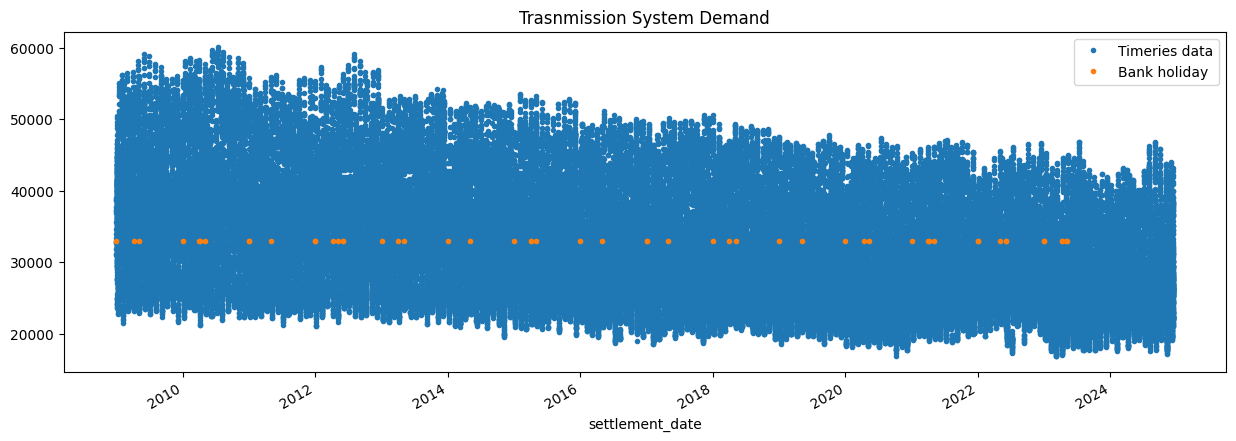

In [ ]:
# Set date as the index and turn into datetime type
df_plot = df.copy()
df_plot = df_plot.set_index("settlement_date")
df_plot.index = pd.to_datetime(df_plot.index)

fig, ax = plt.subplots(figsize=(15, 5))
df_plot["tsd"].plot(
    style=".", ax=ax, title="Trasnmission System Demand", label="Timeries data"
)
(df_plot.query("is_holiday == 1")["is_holiday"] * 33000).plot(
    style=".", ax=ax, label="Bank holiday"
)
ax.legend();

## Check Duplicates

In [ ]:
# Check for any duplicates in the dataset
df.duplicated().sum()

np.int64(0)

## Check Missing Value

In [ ]:
df.isna().sum()

settlement_date              0
settlement_period            0
period_hour                  0
nd                           0
tsd                          0
england_wales_demand         0
embedded_wind_generation     0
embedded_wind_capacity       0
embedded_solar_generation    0
embedded_solar_capacity      0
non_bm_stor                  0
pump_storage_pumping         0
ifa_flow                     0
ifa2_flow                    0
britned_flow                 0
moyle_flow                   0
east_west_flow               0
nemo_flow                    0
is_holiday                   0
dtype: int64

In [ ]:
df.isnull().sum()

settlement_date              0
settlement_period            0
period_hour                  0
nd                           0
tsd                          0
england_wales_demand         0
embedded_wind_generation     0
embedded_wind_capacity       0
embedded_solar_generation    0
embedded_solar_capacity      0
non_bm_stor                  0
pump_storage_pumping         0
ifa_flow                     0
ifa2_flow                    0
britned_flow                 0
moyle_flow                   0
east_west_flow               0
nemo_flow                    0
is_holiday                   0
dtype: int64

## Cek Outliers dan Distribusi

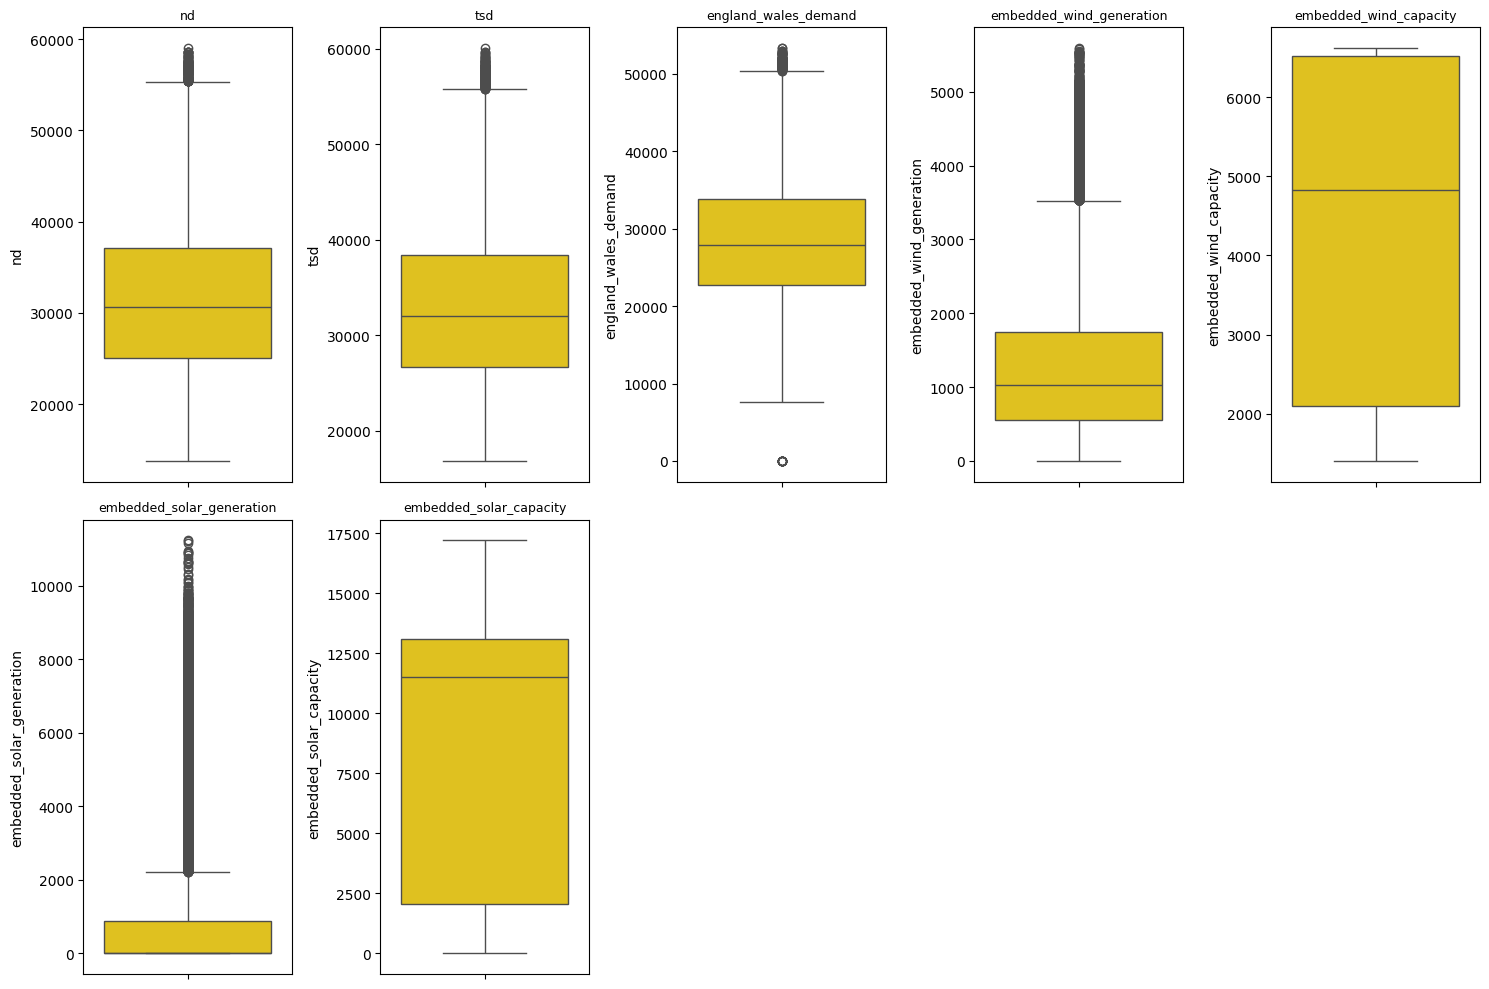

In [ ]:
plt.figure(figsize=(15, 10))

# Daftar kolom
features = [
    'nd', 'tsd', 'england_wales_demand', 'embedded_wind_generation',
    'embedded_wind_capacity', 'embedded_solar_generation',
    'embedded_solar_capacity'
]

# Jumlah kolom per baris
import math
cols = 5
rows = math.ceil(len(features) / cols)

for i, col in enumerate(features):
    plt.subplot(rows, cols, i + 1)
    sns.boxplot(y=df[col], color='gold')
    plt.title(col, fontsize=9)
    plt.tight_layout()

plt.show()

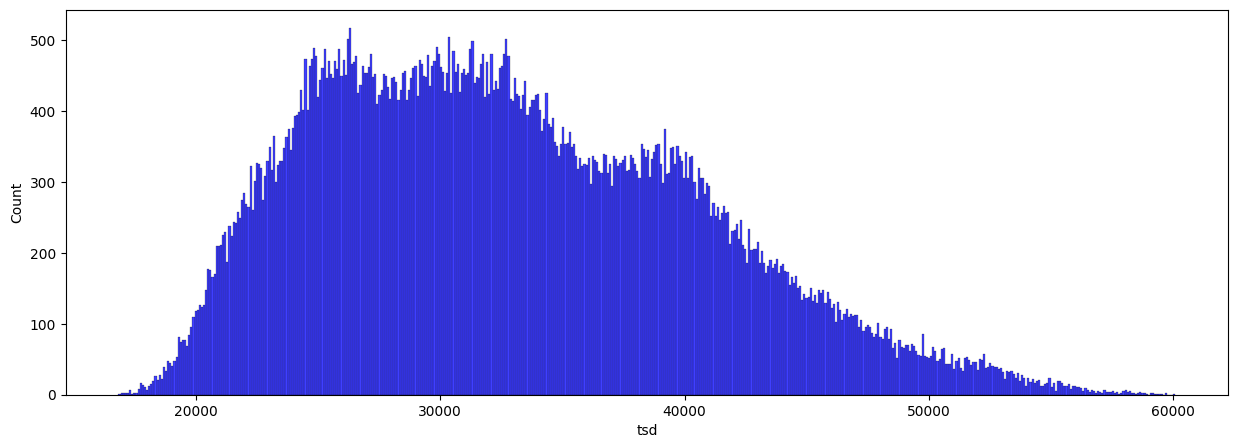

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))

sns.histplot(data=df, x="tsd", bins=500, ax=ax, color="b");

***No duplicate, missing value, and outliers found in dataset. Jika ada outliers terdeteksi, namun masih make sense karena data masih terdistribusi dengan baik***

## Add New Features

* Membuat fitur tambahan berbasis waktu (datetime features) dari index dataframe yang berupa timestamp. Fitur-fitur ini penting untuk membantu model machine learning mengenali pola musiman (seasonality) dan tren waktu
* Menambahkan fitur lag (tunda waktu), yaitu nilai konsumsi listrik di hari yang sama tapi pada tahun-tahun sebelumnya.

In [ ]:
# Add datetime features
def create_features(dfx: pd.DataFrame) -> pd.DataFrame:
    out = dfx.copy()
    iso = out.index.isocalendar()
    out["day_of_month"] = out.index.day
    out["day_of_week"]  = out.index.dayofweek
    out["day_of_year"]  = out.index.day_of_year
    out["quarter"]      = out.index.quarter
    out["month"]        = out.index.month
    out["year"]         = out.index.year
    # gunakan Int64 (nullable) agar tidak error kalau ada NA
    out["week_of_year"] = iso.week.astype("Int64")
    return out

In [ ]:
# Add Lag Features
def add_lags(dfx: pd.DataFrame) -> pd.DataFrame:
    out = dfx.copy()
    out = out[~out.index.isna()]

    target_col = "tsd" if "tsd" in out.columns else ("total_demand" if "total_demand" in out.columns else None)
    if target_col is None:
        raise KeyError("Tidak menemukan kolom target 'tsd' atau 'total_demand'.")

    target_map = out[target_col].to_dict()
    out["lag1"] = (out.index - pd.Timedelta(days=364)).map(target_map)
    out["lag2"] = (out.index - pd.Timedelta(days=728)).map(target_map)
    out["lag3"] = (out.index - pd.Timedelta(days=1092)).map(target_map)
    return out

In [ ]:
df = create_features(df)
df = add_lags(df)

df.head()

settlement_date  settlement_period period_hour     nd  \
timestamp                                                                       
2009-01-01 00:00:00 2009-01-01 00:00:00                  1     0:00:00  37910   
2009-01-01 00:30:00 2009-01-01 00:30:00                  2     0:30:00  38047   
2009-01-01 01:00:00 2009-01-01 01:00:00                  3     1:00:00  37380   
2009-01-01 01:30:00 2009-01-01 01:30:00                  4     1:30:00  36426   
2009-01-01 02:00:00 2009-01-01 02:00:00                  5     2:00:00  35687   

                       tsd  england_wales_demand  embedded_wind_generation  \
timestamp                                                                    
2009-01-01 00:00:00  38704                 33939                        54   
2009-01-01 00:30:00  38964                 34072                        53   
2009-01-01 01:00:00  38651                 33615                        53   
2009-01-01 01:30:00  37775                 32526                        50   
2009-01-01 02:00:00  37298                 31877                        50   

                     embedded_wind_capacity  embedded_solar_generation  \
timestamp                                                                
2009-01-01 00:00:00                    1403                          0   
2009-01-01 00:30:00                    1403                          0   
2009-01-01 01:00:00                    1403                          0   
2009-01-01 01:30:00                    1403                          0   
2009-01-01 02:00:00                    1403                          0   

                     embedded_solar_capacity  ...  day_of_month  day_of_week  \
timestamp                                     ...                              
2009-01-01 00:00:00                        0  ...             1            3   
2009-01-01 00:30:00                        0  ...             1            3   
2009-01-01 01:00:00                        0  ...             1            3   
2009-01-01 01:30:00                        0  ...             1            3   
2009-01-01 02:00:00                        0  ...             1            3   

                     day_of_year  quarter  month  year  week_of_year  lag1  \
timestamp                                                                    
2009-01-01 00:00:00            1        1      1  2009             1   NaN   
2009-01-01 00:30:00            1        1      1  2009             1   NaN   
2009-01-01 01:00:00            1        1      1  2009             1   NaN   
2009-01-01 01:30:00            1        1      1  2009             1   NaN   
2009-01-01 02:00:00            1        1      1  2009             1   NaN   

                     lag2  lag3  
timestamp                        
2009-01-01 00:00:00   NaN   NaN  
2009-01-01 00:30:00   NaN   NaN  
2009-01-01 01:00:00   NaN   NaN  
2009-01-01 01:30:00   NaN   NaN  
2009-01-01 02:00:00   NaN   NaN  

[5 rows x 29 columns]

# **EDA**

## Yearly Consumption

In [ ]:
start_year = 2009
end_year = 2023
years = np.arange(start_year, end_year+1)

colors = ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 360, years.shape[0])]

fig = go.Figure(data=[go.Box(
    y=df.tsd[df.settlement_date.dt.year == year],
    marker_color=colors[i-1],
    name=str(year),
    showlegend=False
    ) for i, year in enumerate(years)])

fig.update_layout(
    title=dict(
        text='Electricity consumption by Year',
        x=0.5
    ),
    xaxis=dict(
        title='month',
    ),
    yaxis = {'title': 'Electricity demand (MW)'},
    margin=dict(r=10,b=50,l=60)
)

## Monthly Consumption

In [ ]:
N = 12
colors = ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 360, N)]

fig = go.Figure(data=[go.Box(
    y=df.tsd[df.settlement_date.dt.month == i],
    marker_color=colors[i-1],
    name=i,
    showlegend=False
    ) for i in range(1, N+1)])

fig.update_layout(
    title=dict(
        text='Electricity consumption by months',
        x=0.5
    ),
    xaxis=dict(
        title='month',
    ),
    yaxis = {'title': 'Electricity demand (MW)'},
    margin=dict(r=10,b=50,l=60)
)

## Hourly Consumption

In [ ]:
N = 24
colors = ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 360, N)]


fig = go.Figure()

for hour in range(1, N+1):
    # Ambil dua settlement period per jam: (2n-1, 2n)
    period1, period2 = 2*hour - 1, 2*hour
    hourly_data = df[(df['settlement_period'].isin([period1, period2]))]['tsd']

    fig.add_trace(go.Box(
        y=hourly_data,
        marker_color=colors[hour-1],
        name=str(hour),
        showlegend=False
    ))

fig.update_layout(
    title=dict(text='Electricity consumption by hours', x=0.5),
    xaxis=dict(title='Hour'),
    yaxis=dict(title='Electricity demand (MW)'),
    margin=dict(r=10, b=50, l=60)
)

fig.show()

## Daily Consumption

In [ ]:
df['day_of_week'] = df['settlement_date'].dt.day_name()

fig = px.box(
    df,
    x='day_of_week',
    y='tsd',
    category_orders={
        "day_of_week": ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
    },
    title='Daily Distribution of Electricity Consumption and Holiday Effect',
    labels={
        "day_of_week": "Day of the Week",
        "tsd": "Electricity Demand (MW)",
    },
    template='plotly_white'
)

fig.show()

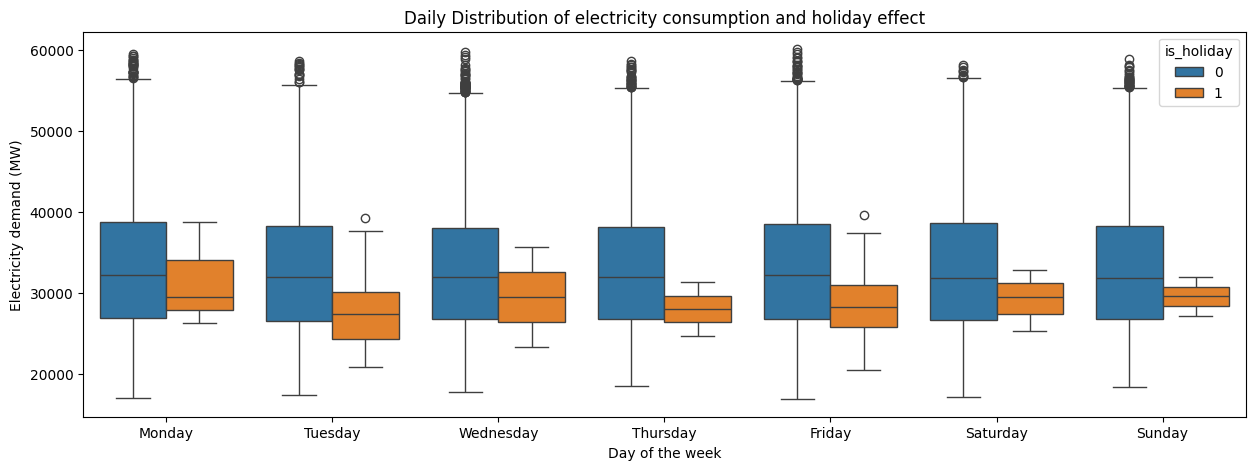

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="day_of_week", y="tsd", data=df, hue="is_holiday", ax=ax)

ax.set_xticklabels(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)
ax.set_xlabel("Day of the week")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Daily Distribution of electricity consumption and holiday effect");

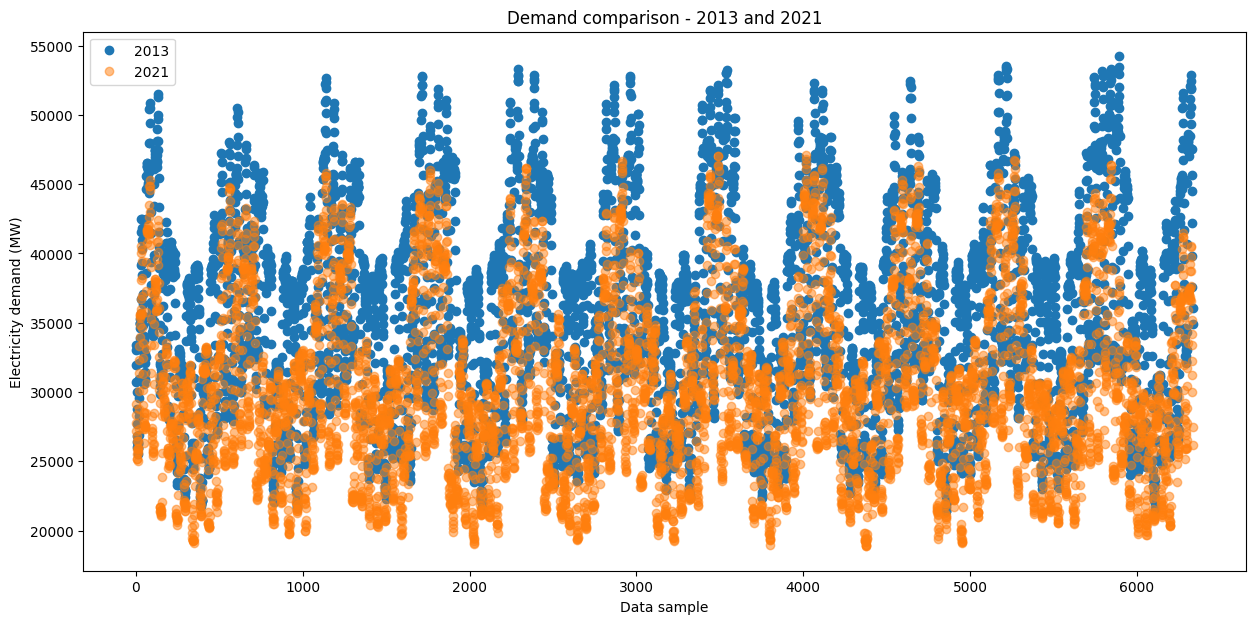

In [ ]:
fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(
    range(len(df.loc[(df.index > "01-01-2013") & (df.index < "12-01-2013")]["tsd"])),
    df.loc[(df.index > "01-01-2013") & (df.index < "12-01-2013")]["tsd"],
    "o",
    label="2013",
)

ax.plot(
    range(len(df.loc[(df.index > "01-01-2021") & (df.index < "12-01-2021")]["tsd"])),
    df.loc[(df.index > "01-01-2021") & (df.index < "12-01-2021")]["tsd"],
    "o",
    alpha=0.5,
    label="2021",
)
ax.set_xlabel("Data sample")
ax.set_ylabel("Electricity demand (MW)")
ax.legend(loc="best")
ax.set_title("Demand comparison - 2013 and 2021");

## Heatmap

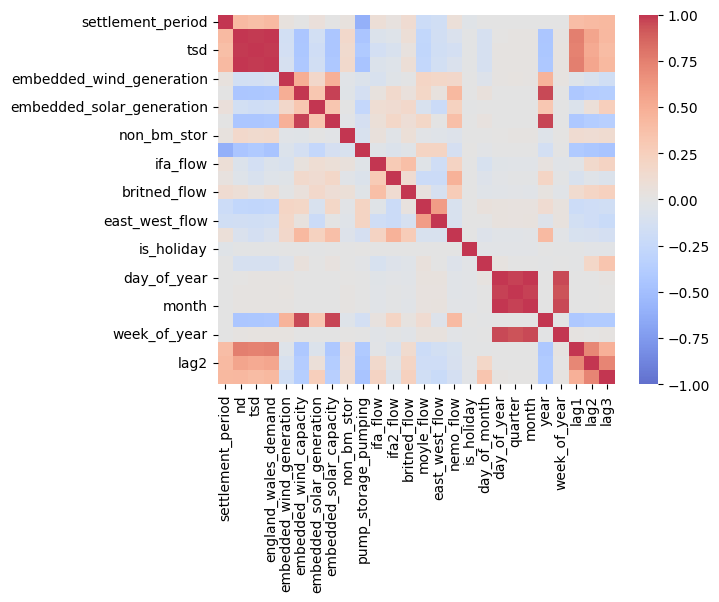

In [ ]:
sns.heatmap(
    df.select_dtypes(include=np.number).corr(),
    cmap=sns.color_palette("coolwarm", as_cmap=True),
    vmax=1, vmin=-1,
    alpha=0.8
)
plt.show()

# **Split Dataset**

In [ ]:
df['day_of_week'] = df['settlement_date'].dt.dayofweek

In [ ]:
print("Tanggal paling awal :", df.index.min())
print("Tanggal paling akhir:", df.index.max())

Tanggal paling awal : 2009-01-01 00:00:00
Tanggal paling akhir: 2024-12-11 23:30:00


In [ ]:
threshold_date_1 = "06-01-2019"
threshold_date_2 = "06-01-2022"
train_data = df.loc[df.index < threshold_date_1]
test_data = df.loc[(df.index >= threshold_date_1) & (df.index < threshold_date_2)]
hold_out_data = df.loc[df.index >= threshold_date_2]

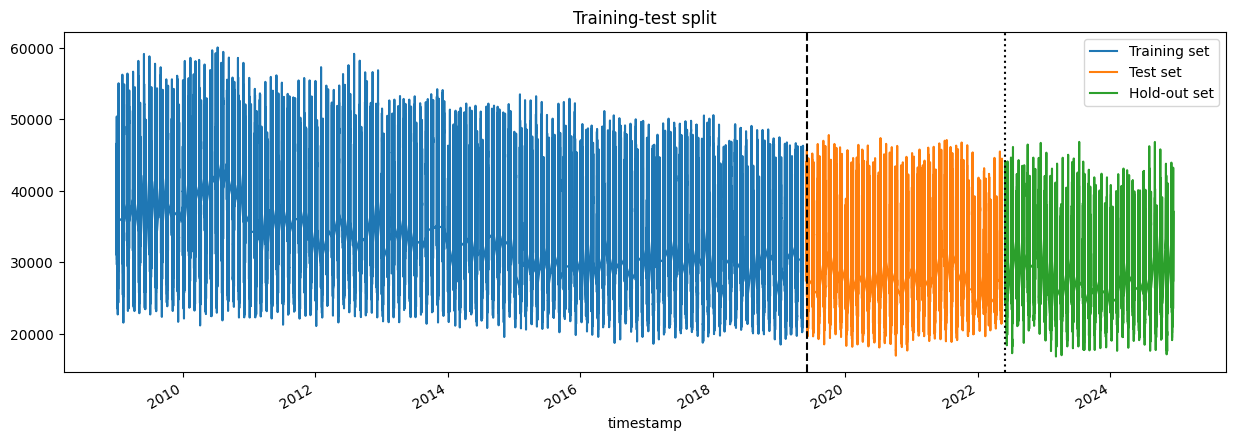

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
train_data["tsd"].plot(ax=ax, label="Training set")
test_data["tsd"].plot(ax=ax, label="Test set")
hold_out_data["tsd"].plot(ax=ax, label="Hold-out set")
ax.axvline(threshold_date_1, color="k", ls="--")
ax.axvline(threshold_date_2, color="k", ls=":")
ax.set_title("Training-test split")
plt.legend();

In [ ]:
# Define the features and target variable
FEATURES = [
    "is_holiday",
    "settlement_period",
    "day_of_month",
    "day_of_week",
    "day_of_year",
    "quarter",
    "month",
    "year",
    "week_of_year",
]
TARGET = "tsd"

# Prepare the training, testing and hold-out data
X_train = train_data[FEATURES]
y_train = train_data[TARGET]

X_test = test_data[FEATURES]
y_test = test_data[TARGET]

X_hold_out = hold_out_data[FEATURES]
y_hold_out = hold_out_data[TARGET]

# **Timeseries Model**

## **XGBoost**

In [ ]:
import xgboost as xgb

xgb_simple = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=3,
    learning_rate=0.01,
    early_stopping_rounds=50,
    random_state=43,
)

xgb_simple.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_hold_out, y_hold_out)],
    verbose=100,
)

[0]	validation_0-rmse:7695.93898	validation_1-rmse:8534.37978
[100]	validation_0-rmse:5095.72874	validation_1-rmse:6623.62033
[200]	validation_0-rmse:4122.11553	validation_1-rmse:5686.09456
[300]	validation_0-rmse:3643.55991	validation_1-rmse:5180.24230
[400]	validation_0-rmse:3401.18455	validation_1-rmse:4902.79500
[499]	validation_0-rmse:3272.14065	validation_1-rmse:4761.10144


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

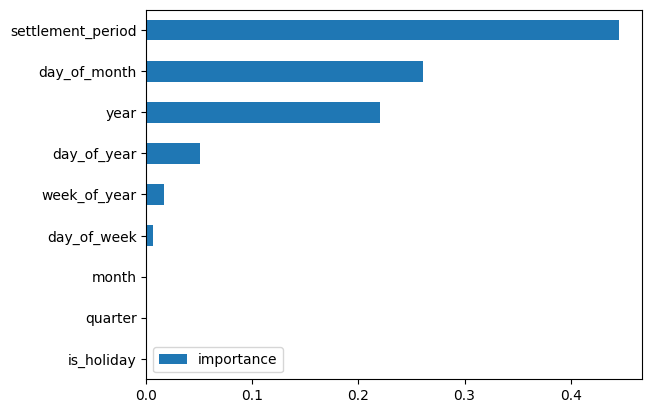

In [ ]:
feat_imp_1 = pd.DataFrame(
    data=xgb_simple.feature_importances_,
    index=xgb_simple.get_booster().feature_names,
    columns=["importance"],
)

feat_imp_1.sort_values("importance", ascending=True, inplace=True)

feat_imp_1.plot(kind="barh");

### Data Set Train

In [ ]:
result_frame_train = y_train.to_frame()
result_frame_train["pred_xgb_simple"] = xgb_simple.predict(X_train)

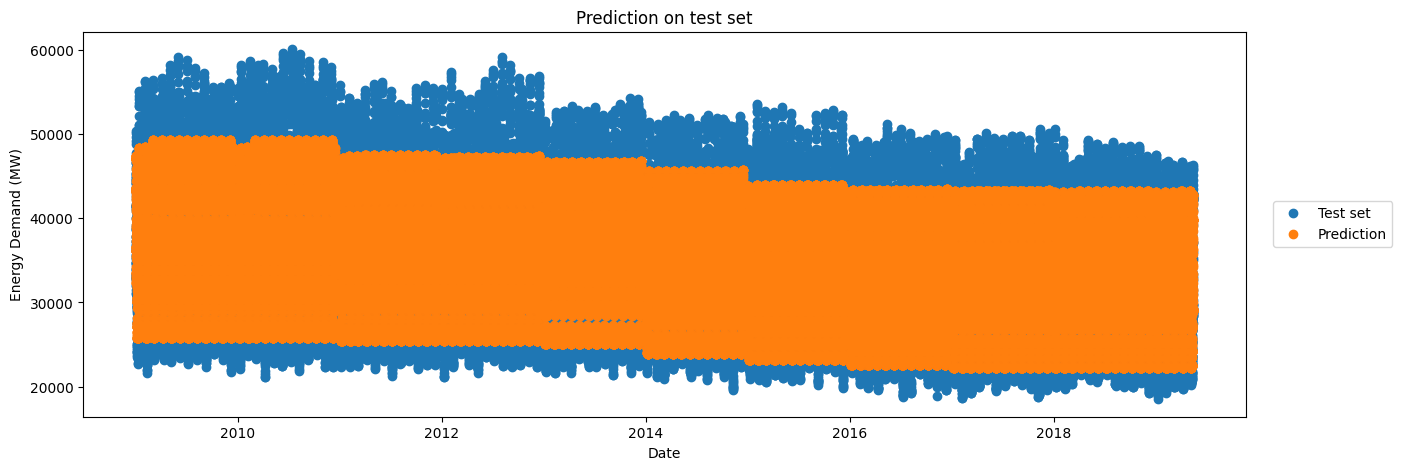

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(result_frame_train.index, result_frame_train["tsd"], "o", label="Test set")
ax.plot(result_frame_train.index, result_frame_train["pred_xgb_simple"], "o", label="Prediction")

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

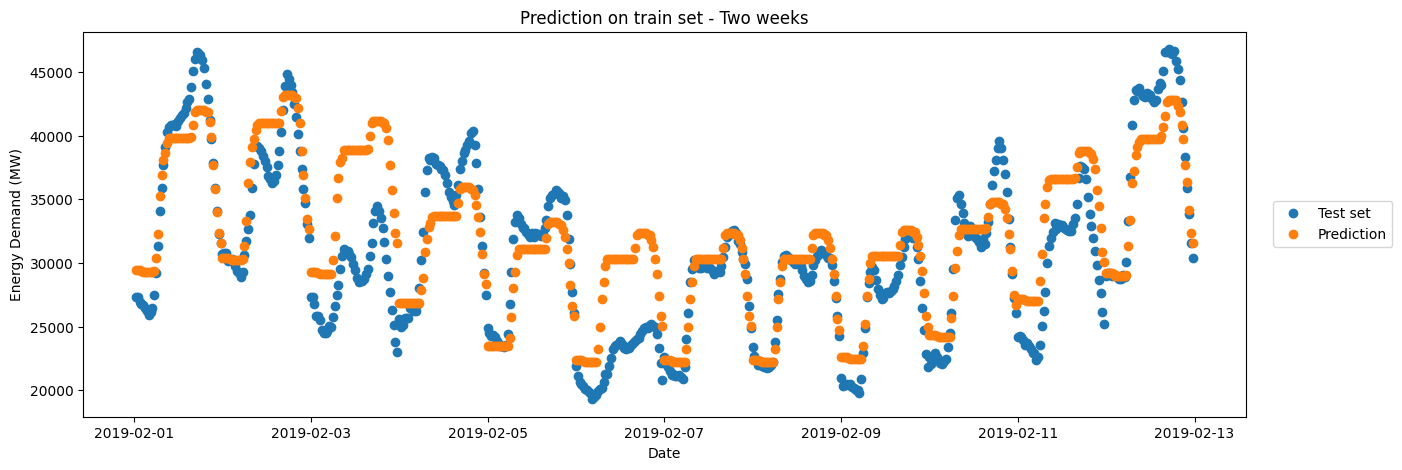

In [ ]:
begin = "02-01-2019"
end = "02-14-2019"

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(
    result_frame_train.loc[(result_frame_train.index > begin) & (result_frame_train.index < end)].index,
    result_frame_train.loc[(result_frame_train.index > begin) & (result_frame_train.index < end)]["tsd"],
    "o",
    label="Test set",
)

ax.plot(
    result_frame_train.loc[(result_frame_train.index > begin) & (result_frame_train.index < end)].index,
    result_frame_train.loc[(result_frame_train.index > begin) & (result_frame_train.index < end)][
        "pred_xgb_simple"
    ],
    "o",
    label="Prediction",
)

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on train set - Two weeks")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

**Evaluasi Model Train**

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate Mean Absolute Pertange Error given the true and
    predicted values

    Args:
        - y_true: true values
        - y_pred: predicted values

    Returns:
        - mape: MAPE value for the given predicted values
    """

    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

In [ ]:
mape_xgboost_simple = mean_absolute_percentage_error(
    y_train, result_frame_train["pred_xgb_simple"]
)

rmse_xgboost_simple = np.sqrt(mean_squared_error(y_train, result_frame_train["pred_xgb_simple"]))

print(
    "Mean Absolute Percentage Error of the simple model in train is: %.2f" % mape_xgboost_simple
)

print(
    "Root Mean Squared Error of the simple models in train is: %.2f MW" % rmse_xgboost_simple
)

Mean Absolute Percentage Error of the simple model in train is: 7.46
Root Mean Squared Error of the simple models in train is: 3272.14 MW


### Data Set Test

In [ ]:
result_frame_test = y_test.to_frame()
result_frame_test["pred_xgb_simple"] = xgb_simple.predict(X_test)

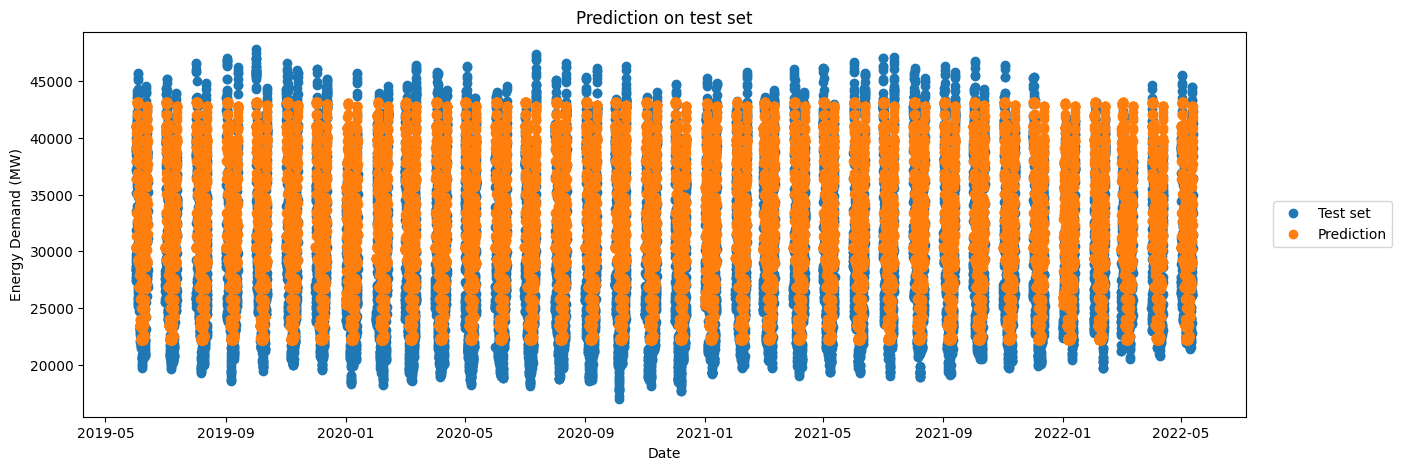

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(result_frame_test.index, result_frame_test["tsd"], "o", label="Test set")
ax.plot(result_frame_test.index, result_frame_test["pred_xgb_simple"], "o", label="Prediction")

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

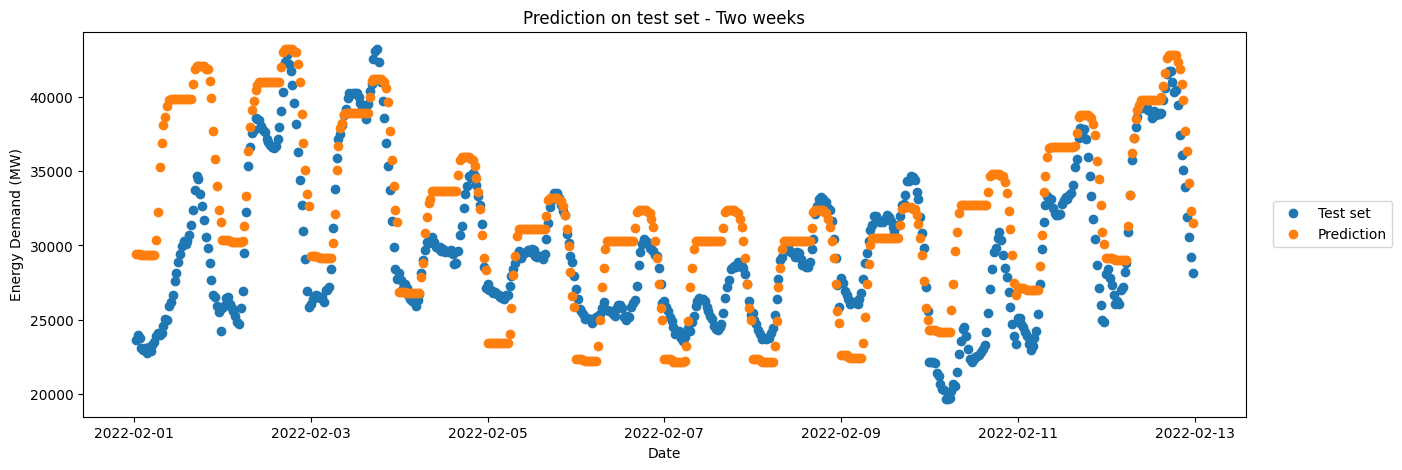

In [ ]:
begin = "02-01-2022"
end = "02-14-2022"

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(
    result_frame_test.loc[(result_frame_test.index > begin) & (result_frame_test.index < end)].index,
    result_frame_test.loc[(result_frame_test.index > begin) & (result_frame_test.index < end)]["tsd"],
    "o",
    label="Test set",
)

ax.plot(
    result_frame_test.loc[(result_frame_test.index > begin) & (result_frame_test.index < end)].index,
    result_frame_test.loc[(result_frame_test.index > begin) & (result_frame_test.index < end)][
        "pred_xgb_simple"
    ],
    "o",
    label="Prediction",
)

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set - Two weeks")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

**Evaluasi Model Test**

In [ ]:
mape_xgboost_simple = mean_absolute_percentage_error(
    y_test, result_frame_test["pred_xgb_simple"]
)

rmse_xgboost_simple = np.sqrt(mean_squared_error(y_test, result_frame_test["pred_xgb_simple"]))

print(
    "Mean Absolute Percentage Error of the simple model in test is: %.2f" % mape_xgboost_simple
)

print(
    "Root Mean Squared Error of the simple models in test is: %.2f MW" % rmse_xgboost_simple
)

Mean Absolute Percentage Error of the simple model in test is: 11.39
Root Mean Squared Error of the simple models in test is: 4003.03 MW


## **Dengan Cross Validation**

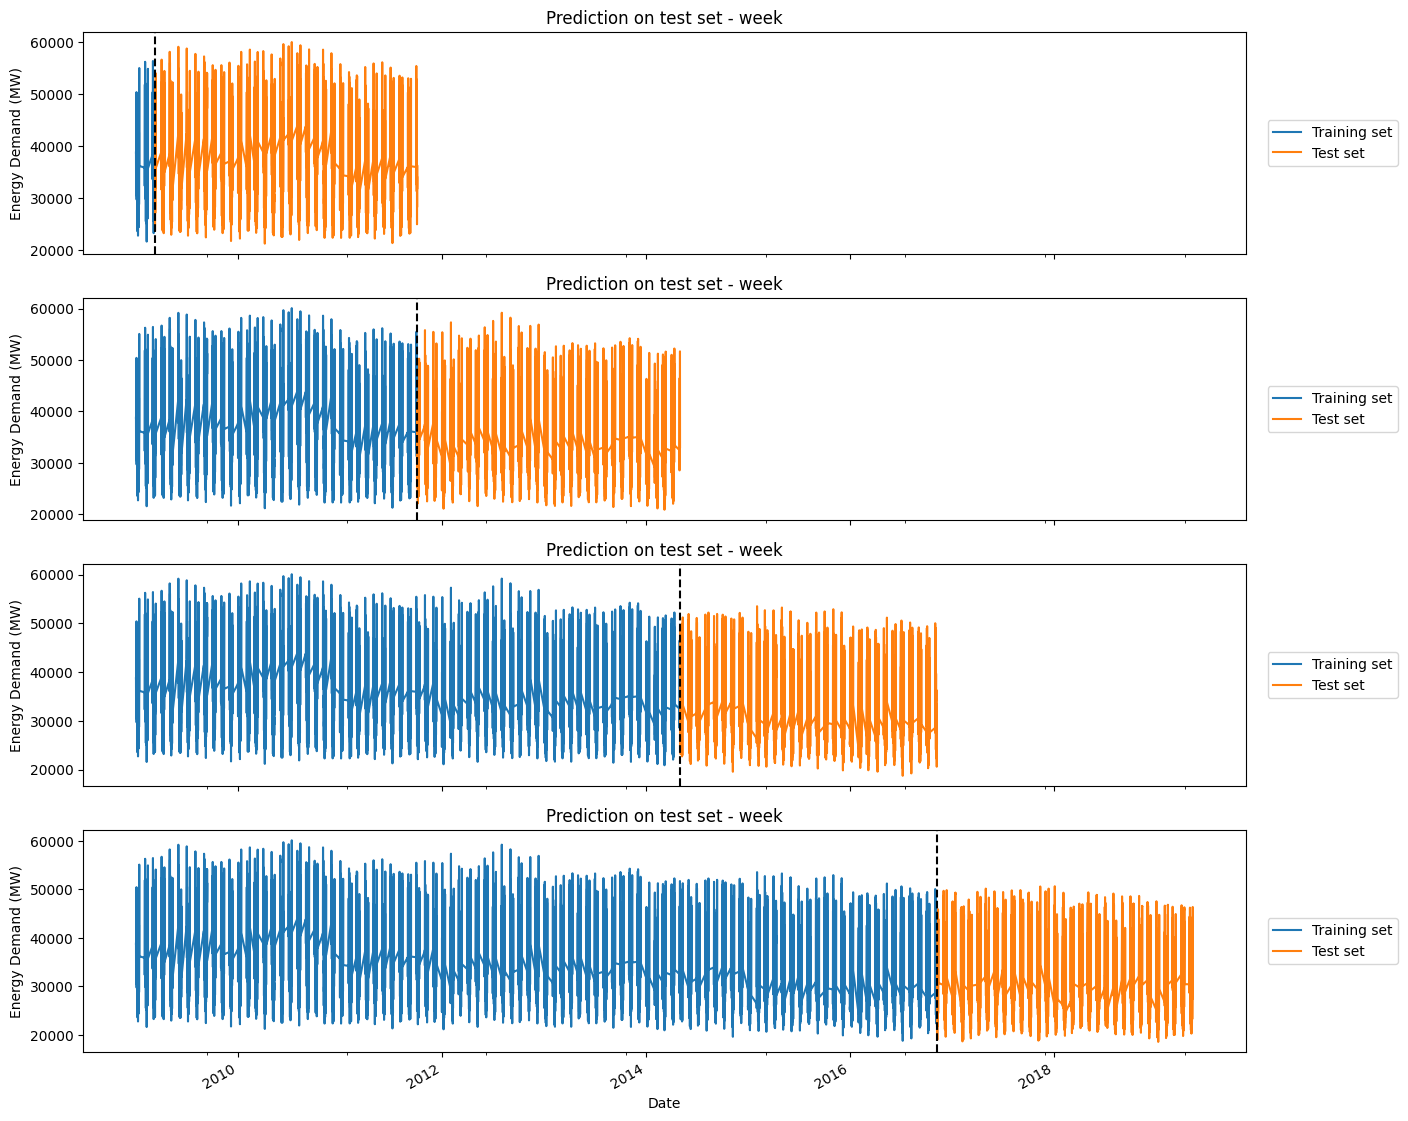

In [ ]:
n_years_test = 1
tss = TimeSeriesSplit(n_splits=4, test_size=48 * 365 * n_years_test, gap=48)

fig, axes = plt.subplots(4, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_index, test_index in tss.split(df[df.index<threshold_date_1]):

    train = df.iloc[train_index]
    test = df.iloc[test_index]

    train["tsd"].plot(
        ax=axes[fold], label="Training set", title=f"Data Train-test split fold {fold}",
    )
    test["tsd"].plot(ax=axes[fold], label="Test set")
    axes[fold].axvline(test.index.min(), color="k", ls="--")
    axes[fold].legend(loc="center", bbox_to_anchor=(1.075, 0.5))

    axes[fold].set_title("Prediction on test set - week")
    axes[fold].set_ylabel("Energy Demand (MW)")
    axes[fold].set_xlabel("Date");
    fold += 1

**Combine with Grid SearchCV**

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_percentage_error,
    make_scorer,
)

In [ ]:
# DATA & FITUR (asumsi train_data/test_data sudah siap)

FEATURES_CV = [
    "settlement_period", "day_of_month", "day_of_week", "day_of_year",
    "quarter", "month", "year", "week_of_year",
    "lag1", "lag2", "lag3", "is_holiday",
]
TARGET = "tsd"

X_train_cv = train_data[FEATURES_CV].copy()
y_train_cv = train_data[TARGET].copy()
X_test_cv  = test_data[FEATURES_CV].copy()
y_test_cv  = test_data[TARGET].copy()


# SANITY CHECK DTYPE (menghindari object/datetime)

def coerce_object_to_numeric(X: pd.DataFrame) -> pd.DataFrame:
    # object -> category codes
    obj_cols = X.select_dtypes(include="object").columns.tolist()
    for c in obj_cols:
        X[c] = X[c].astype("category").cat.codes.astype("int16")
    # pastikan tidak ada datetime tersisa
    dt_cols = X.select_dtypes(include=["datetime64[ns]", "datetime64[ns, UTC]"]).columns.tolist()
    if dt_cols:
        raise ValueError(f"Kolom datetime masih ada: {dt_cols} (extract dulu jadi fitur numerik)")
    return X

X_train_cv = coerce_object_to_numeric(X_train_cv)
X_test_cv  = coerce_object_to_numeric(X_test_cv)

# merapikan int
for c in X_train_cv.columns:
    if str(X_train_cv[c].dtype).startswith("int"):
        X_train_cv[c] = X_train_cv[c].astype("int32")
        X_test_cv[c]  = X_test_cv[c].astype("int32")


# TIME SERIES SPLIT + SCORER (MAPE)

n_years_test = 1
tss = TimeSeriesSplit(n_splits=4, test_size=48 * 365 * n_years_test, gap=48)

mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

# ESTIMATOR & GRID
estimator = xgb.XGBRegressor(
    learning_rate=0.01,
    booster="gbtree",
    tree_method="hist",
    random_state=43,
    eval_metric="rmse",  # metrik internal; GridSearch pakai MAPE
)

param_search = {
    "max_depth": [3, 5],
    "n_estimators": [350, 500, 650],
    "subsample": [0.95, 0.8, 0.7],
    # (opsional) tambah regularisasi bila perlu:
    # "reg_lambda": [1.0, 5.0, 10.0],
    # "reg_alpha": [0.0, 0.1, 0.5],
    # "min_child_weight": [1, 5, 10],
    # "colsample_bytree": [0.8, 1.0],
}

xgb_search = GridSearchCV(
    estimator=estimator,
    param_grid=param_search,
    scoring=mape_scorer,   # fokus turunkan MAPE
    cv=tss,
    verbose=2,
    n_jobs=-1,
    error_score="raise",
)


# RID SEARCH FIT

xgb_search.fit(X_train_cv, y_train_cv)
print("✅ Best parameters:", xgb_search.best_params_)
print("✅ Best CV (neg MAPE):", xgb_search.best_score_)
print("✅ Best CV MAPE:", -xgb_search.best_score_)

best_params = xgb_search.best_params_

# Validasi for early stopping
# ambil beberapa hari terakhir dari training sebagai validation

valid_horizon = 48 * 14  # contoh: 14 hari terakhir (48 interval per hari)
X_tr, y_tr = X_train_cv.iloc[:-valid_horizon], y_train_cv.iloc[:-valid_horizon]
X_val, y_val = X_train_cv.iloc[-valid_horizon:],  y_train_cv.iloc[-valid_horizon:]


Fitting 4 folds for each of 18 candidates, totalling 72 fits
✅ Best parameters: {'max_depth': 5, 'n_estimators': 650, 'subsample': 0.7}
✅ Best CV (neg MAPE): -0.08543357625603676
✅ Best CV MAPE: 0.08543357625603676


In [ ]:
# FINAL MODEL

final_model = xgb.XGBRegressor(
    learning_rate=0.01,
    tree_method="hist",
    random_state=43,
    eval_metric="rmse",
    early_stopping_rounds=50,
    **best_params,
)

final_model.fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val)],
    verbose=True
)

[0]	validation_0-rmse:7390.76500
[1]	validation_0-rmse:7324.91111
[2]	validation_0-rmse:7260.39193
[3]	validation_0-rmse:7198.13498
[4]	validation_0-rmse:7134.83412
[5]	validation_0-rmse:7072.31693
[6]	validation_0-rmse:7010.73546
[7]	validation_0-rmse:6949.25306
[8]	validation_0-rmse:6889.38197
[9]	validation_0-rmse:6831.58591
[10]	validation_0-rmse:6775.10245
[11]	validation_0-rmse:6721.54615
[12]	validation_0-rmse:6669.79546
[13]	validation_0-rmse:6608.54716
[14]	validation_0-rmse:6554.46703
[15]	validation_0-rmse:6500.59733
[16]	validation_0-rmse:6447.75561
[17]	validation_0-rmse:6395.75384
[18]	validation_0-rmse:6344.15292
[19]	validation_0-rmse:6295.03972
[20]	validation_0-rmse:6241.43925
[21]	validation_0-rmse:6190.96737
[22]	validation_0-rmse:6140.48512
[23]	validation_0-rmse:6090.23081
[24]	validation_0-rmse:6042.03031
[25]	validation_0-rmse:5993.46157
[26]	validation_0-rmse:5945.27360
[27]	validation_0-rmse:5897.69847
[28]	validation_0-rmse:5851.16146
[29]	validation_0-rmse:5

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=650,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
# Do evaluation on data test
y_pred = final_model.predict(X_test_cv)

# RMSE manual
mse = mean_squared_error(y_test_cv, y_pred)
rmse = np.sqrt(mse)

# MAPE
mape = mean_absolute_percentage_error(y_test_cv, y_pred)

print(f" Final Test RMSE : {rmse:,.2f} MW")
print(f" Final Test MAPE : {mape:.4f}")

 Final Test RMSE : 3,529.65 MW
 Final Test MAPE : 0.0963


In [ ]:
xgb_search.best_params_

{'max_depth': 5, 'n_estimators': 650, 'subsample': 0.7}

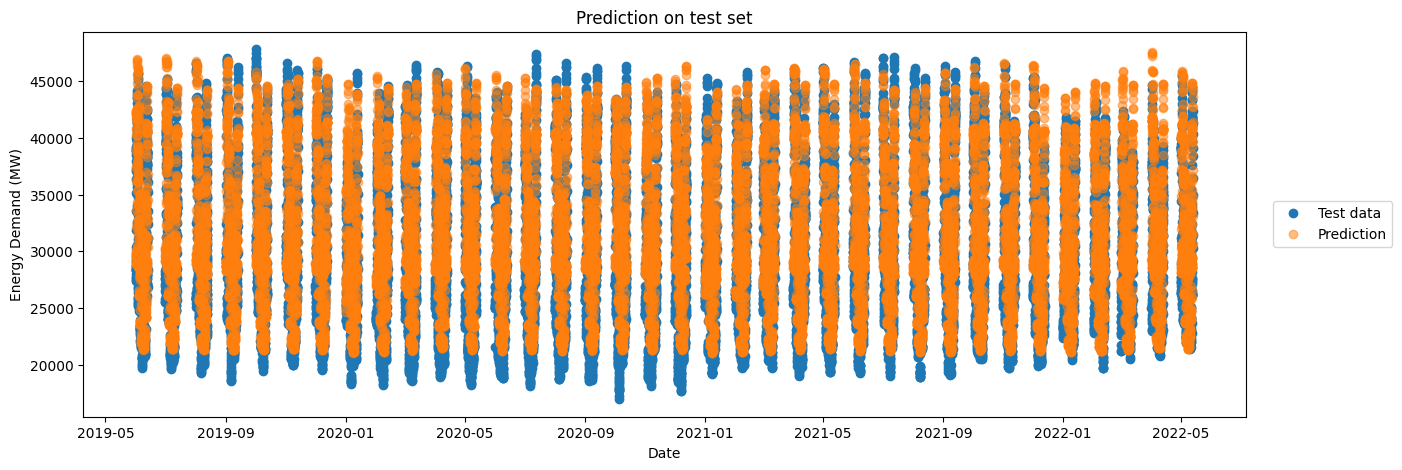

In [ ]:
result_frame_test["pred_xgb_cv_gs"] = xgb_search.predict(X_test_cv)

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(result_frame_test.index, result_frame_test["tsd"], "o", label="Test data")
ax.plot(
    result_frame_test.index,
    result_frame_test["pred_xgb_cv_gs"],
    "o",
    label="Prediction",
    alpha=0.5,
)

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");


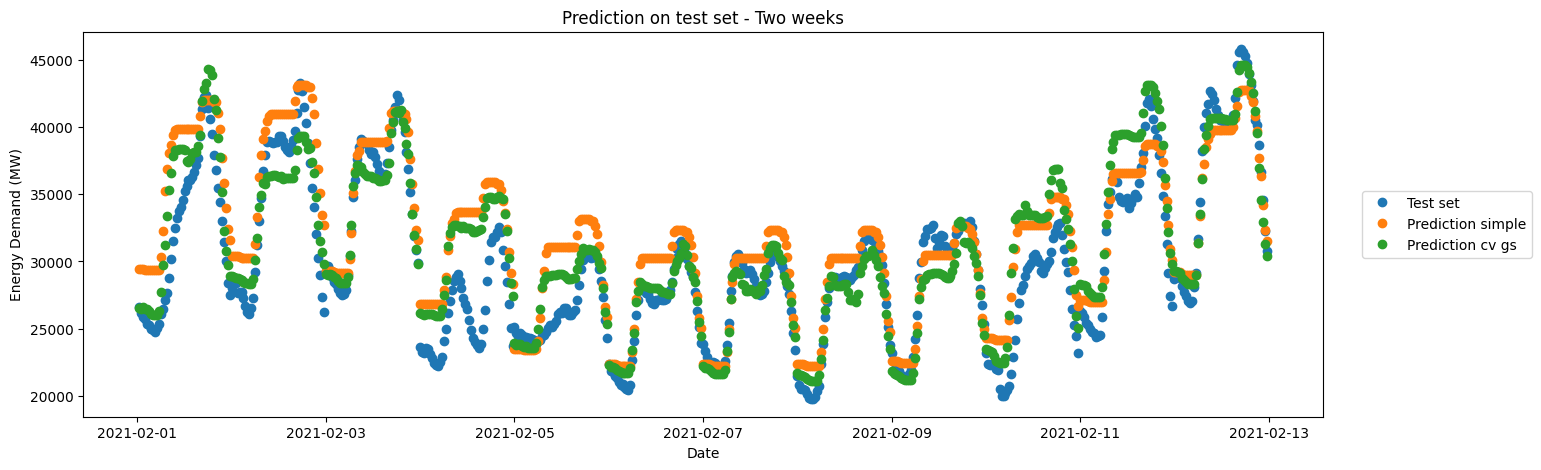

In [ ]:
begin = "02-01-2021"
end = "02-14-2021"

fig, ax = plt.subplots(figsize=(16, 5))

ax.plot(
    result_frame_test.loc[(result_frame_test.index > begin) & (result_frame_test.index < end)].index,
    result_frame_test.loc[(result_frame_test.index > begin) & (result_frame_test.index < end)]["tsd"],
    "o",
    label="Test set",
)

ax.plot(
    result_frame_test.loc[(result_frame_test.index > begin) & (result_frame_test.index < end)].index,
    result_frame_test.loc[(result_frame_test.index > begin) & (result_frame_test.index < end)][
        "pred_xgb_simple"
    ],
    "o",
    label="Prediction simple",
)

ax.plot(
    result_frame_test.loc[(result_frame_test.index > begin) & (result_frame_test.index < end)].index,
    result_frame_test.loc[(result_frame_test.index > begin) & (result_frame_test.index < end)][
        "pred_xgb_cv_gs"
    ],
    "o",
    label="Prediction cv gs",
)

ax.legend(loc="center", bbox_to_anchor=(1.1, 0.5))

ax.set_title("Prediction on test set - Two weeks")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");


# Prediction

In [ ]:
X_all = df[FEATURES_CV].copy()
y_all = df[TARGET].copy()

xgb_best = xgb_search.best_estimator_
xgb_best.set_params(n_jobs=-1)

# gunakan full retrain tanpa ES, tapi batasi jumlah tree sesuai best_iteration dari GS
best_n = xgb_search.best_estimator_.get_params()["n_estimators"]
xgb_best.set_params(n_estimators=best_n)

xgb_best.fit(X_all, y_all, verbose=False)



XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=650,
             n_jobs=-1, num_parallel_tree=None, ...)

In [ ]:
# Buat index untuk 365 hari ke depan
prediction_days = 365
next_slot = df.index.max() + pd.Timedelta("30min")
future_idx = pd.date_range(start=next_slot, periods=48 * prediction_days, freq="30min")

# Build calendar fitur
future_df = pd.DataFrame(index=future_idx)
future_df["settlement_period"] = (future_df.index.hour * 2 + (future_df.index.minute == 30).astype(int) + 1)
future_df["day_of_month"] = future_df.index.day
future_df["day_of_week"]  = future_df.index.dayofweek
future_df["day_of_year"]  = future_df.index.dayofyear
future_df["quarter"]      = ((future_df.index.month - 1) // 3 + 1)
future_df["month"]        = future_df.index.month
future_df["year"]         = future_df.index.year
future_df["week_of_year"] = future_df.index.isocalendar().week
future_df["is_holiday"]   = 0

# Recursive forecasting
last_vals = df[TARGET].dropna().tail(3).values
lag1, lag2, lag3 = last_vals[-1], last_vals[-2], last_vals[-3]
preds = []

for ts in future_df.index:
    row = future_df.loc[[ts]].copy()
    row["lag1"], row["lag2"], row["lag3"] = lag1, lag2, lag3

    # prediksi satu langkah
    y_hat = float(xgb_best.predict(row[FEATURES_CV])[0])
    preds.append(y_hat)

    # geser lag untuk langkah berikutnya
    lag3, lag2, lag1 = lag2, lag1, y_hat

In [ ]:
# Create Data Frame for Prediction
assert len(preds) == len(future_df), f"Mismatch: preds={len(preds)}, future_df={len(future_df)}"

future_df["pred_xgboost"] = preds
future_df = future_df.rename_axis("datetime").reset_index()

display(future_df.head())
display(future_df.tail())

datetime  settlement_period  day_of_month  day_of_week  \
0 2024-12-12 00:00:00                  1            12            3   
1 2024-12-12 00:30:00                  2            12            3   
2 2024-12-12 01:00:00                  3            12            3   
3 2024-12-12 01:30:00                  4            12            3   
4 2024-12-12 02:00:00                  5            12            3   

   day_of_year  quarter  month  year  week_of_year  is_holiday  pred_xgboost  
0          347        4     12  2024            50           0  23616.222656  
1          347        4     12  2024            50           0  23498.365234  
2          347        4     12  2024            50           0  23706.140625  
3          347        4     12  2024            50           0  23469.818359  
4          347        4     12  2024            50           0  23330.289062

datetime  settlement_period  day_of_month  day_of_week  \
17515 2025-12-11 21:30:00                 44            11            3   
17516 2025-12-11 22:00:00                 45            11            3   
17517 2025-12-11 22:30:00                 46            11            3   
17518 2025-12-11 23:00:00                 47            11            3   
17519 2025-12-11 23:30:00                 48            11            3   

       day_of_year  quarter  month  year  week_of_year  is_holiday  \
17515          345        4     12  2025            50           0   
17516          345        4     12  2025            50           0   
17517          345        4     12  2025            50           0   
17518          345        4     12  2025            50           0   
17519          345        4     12  2025            50           0   

       pred_xgboost  
17515  27644.289062  
17516  26818.048828  
17517  25674.449219  
17518  24599.558594  
17519  23822.152344

Text(0.5, 1.0, 'Future demand prediction (365 days, 30-min)')

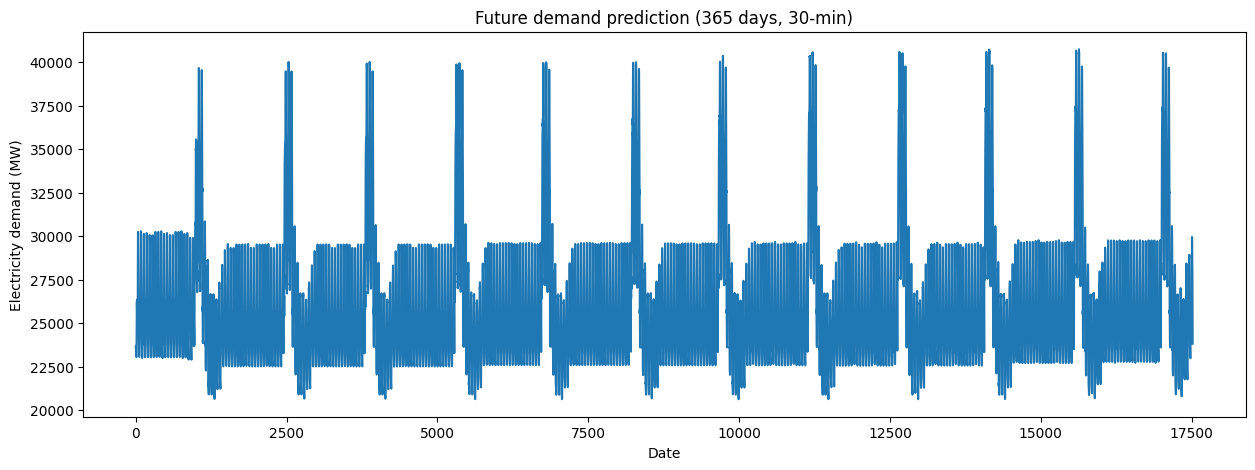

In [ ]:
# Plot Hasil Prediksi untuk 365 hari kedepan
future_df["pred_xgboost"] = preds
ax = future_df["pred_xgboost"].plot(figsize=(15,5))
ax.set_xlabel("Date"); ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Future demand prediction (365 days, 30-min)")